In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import os

In [ ]:
train_dir = '/content/drive/My Drive/New Masks Dataset/Train'
test_dir = '/content/drive/My Drive/New Masks Dataset/Test'
val_dir='/content/drive/My Drive/New Masks Dataset/Validation'

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
conv_base=MobileNetV2(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
conv_base.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [ ]:
#from keras.preprocessing.image import ImageDataGenerator
#from keras.applications.vgg16 import VGG16

#conv_base = VGG16(weights = 'imagenet',include_top = False,input_shape = (224,224,3))
#conv_base.summary()

In [ ]:
for layer in conv_base.layers:
	layer.trainable = False

In [ ]:

from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential
from keras import layers,models,optimizers 
# Although this part can be done also with the functional API, I found that for this simple models, this becomes more intuitive
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation="softmax")) # Finally our activation layer! we use 10 outputs as we have 3 covid case(covid normal varial pnemoniea ) (labels)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dropout (Dropout)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               32113152  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 34,372,162
Trainable params: 32,114,178
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
from keras import optimizers
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001)
learning_rate = 1e-3

checkpoint = ModelCheckpoint("Face_Mask_Dectiction_MobileV2.h5", monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate, clipnorm = 1.), metrics = ['acc'])

In [ ]:

# these are generators for train/test data that will read pictures #found in the defined subfolders of 'data/'


LR = 1e-5
height=224
width=224
channels=3
seed=1337
batch_size = 64 #Number of images to load at each iteration
num_classes = 3
epochs = 10
data_augmentation = True
num_predictions = 20

# Training generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='categorical')

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(val_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical')

train_num = train_generator.samples
validation_num = validation_generator.samples
validation_num

Found 600 images belonging to 2 classes.
Found 306 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


306

In [ ]:
sample_training_images, _ = next(train_generator)

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

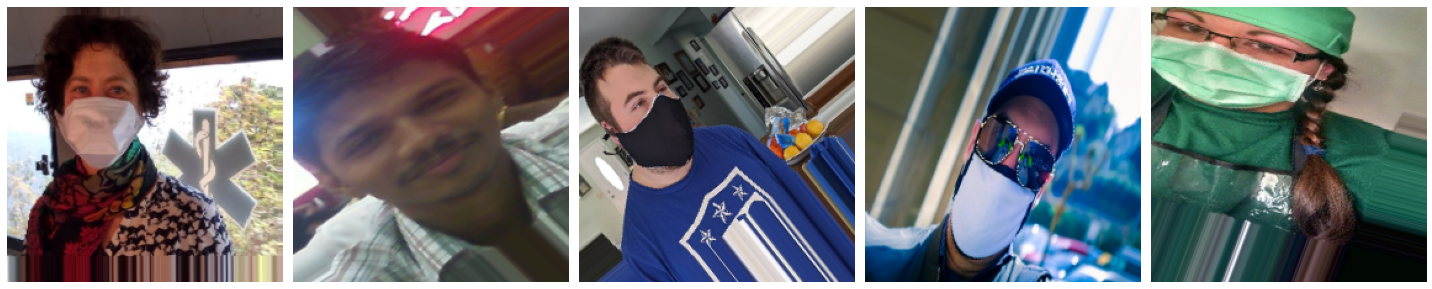

In [ ]:
plotImages(sample_training_images[:5])

In [ ]:
model_history = model.fit(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps= validation_num // batch_size,
                             callbacks=[checkpoint], 
                              verbose = 1)

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 9.8634 - acc: 0.6772  
Epoch 00001: val_acc improved from -inf to 0.99219, saving model to Face_Mask_Dectiction_MobileV2.h5
9/9 [==============================] - 454s 50s/step - loss: 9.8634 - acc: 0.6772 - val_loss: 0.0966 - val_acc: 0.9922
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.2887 - acc: 0.9515
Epoch 00002: val_acc improved from 0.99219 to 0.99609, saving model to Face_Mask_Dectiction_MobileV2.h5
9/9 [==============================] - 16s 2s/step - loss: 0.2887 - acc: 0.9515 - val_loss: 0.0778 - val_acc: 0.9961
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.2483 - acc: 0.9776
Epoch 00003: val_acc did not improve from 0.99609
9/9 [==============================] - 15s 2s/step - loss: 0.2483 - acc: 0.9776 - val_loss: 0.4711 - val_acc: 0.9023
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.1836 - acc: 0.9601
Epoch 00004: val_acc did not improve from 

In [ ]:
path='/content/drive/My Drive/Model_save/Face_Mask_Dectiction_MobileV2.h5'
model.save(path)

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_pred
#validation_generator.classes

Instructions for updating:
Please use Model.predict, which supports generators.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn import metrics
accuracy = accuracy_score(test_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 100.0% 


In [ ]:
class_labels = list(test_generator.class_indices.keys()) 


In [ ]:
print(metrics.classification_report(test_generator.classes, y_pred,target_names=class_labels))

              precision    recall  f1-score   support

        Mask       1.00      1.00      1.00        50
    Non Mask       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

